# A Simple Quantum Classifier

_This notebook explores the creation and use of a model in **PennyLane and PyTorch**_.

**By:** Jacob Cybulski<br>
**Date:** October 2024<br>
**Aims:** The goal of this notebook is to explore PennyLane quantum model creation.<br/>

## Libraries

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/ncng/.pyenv/versions/3.10.9/lib/python310.zip',
 '/home/ncng/.pyenv/versions/3.10.9/lib/python3.10',
 '/home/ncng/.pyenv/versions/3.10.9/lib/python3.10/lib-dynload',
 '',
 '/home/ncng/.local/share/virtualenvs/harmonic-oscillator-pinn-TgSL529C/lib/python3.10/site-packages',
 '.']

In [2]:
### General libraries

import os
import pylab
import math
import time
import copy
import numpy as nnp
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("warning")

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
### Import utilities
from utilities import *

## Load previously prepared data set

Data sets to chose from (require: pip install ucimlrepo):
- <a href="https://archive.ics.uci.edu/dataset/10/automobile" target="_blank">Automobiles</a>:
  This is a database of automobile specs. The task is to either predict the car price or determine its insurance risk (symboling).
- <a href="https://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks" target="_blank">Sonar</a>:
  The task is to discriminate between sonar signals bounced off a mine (metal cylinder) or a rock (roughly cylindrical).
  
_**Data prepared according to the following objectives:**_

- *Fetch and understand data*
- *Select numeric variables only*
- *Deal with missing values*
- *Prepare the label (change it to binary)*
- *Standardise predictors*
- *Reduce dimensionality using PCA*


### Files location

In [4]:
RSRC_STORE = 'rsrc'
RSRC_NAME = 'simple_auto'

### Data set in its original form

In [5]:
from ucimlrepo import fetch_ucirepo

auto = fetch_ucirepo(id=10)

# data (as pandas dataframes) 
X_vars = auto.data.features 
y_class = auto.data.targets 
  
# metadata 
print(auto.metadata['additional_info']['summary'],'\n') 
  
# variable information 
# print(auto.variables) 

ModuleNotFoundError: No module named 'ucimlrepo'

In [6]:
X_vars.head(5)

,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,fuel-system,engine-size,...,length,wheel-base,engine-location,drive-wheels,body-style,num-of-doors,aspiration,fuel-type,make,normalized-losses
0,13495.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN
1,16500.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN
2,16500.0,26,19,5000.0,154.0,9.0,3.47,2.68,mpfi,152,...,171.2,94.5,front,rwd,hatchback,2.0,std,gas,alfa-romero,NaN
3,13950.0,30,24,5500.0,102.0,10.0,3.40,3.19,mpfi,109,...,176.6,99.8,front,fwd,sedan,4.0,std,gas,audi,164.0
4,17450.0,22,18,5500.0,115.0,8.0,3.40,3.19,mpfi,136,...,176.6,99.4,front,4wd,sedan,4.0,std,gas,audi,164.0


### Load data from the store

In [7]:
x_file_path = os.path.join(RSRC_STORE, RSRC_NAME+'_x.pkl')
y_file_path = os.path.join(RSRC_STORE, RSRC_NAME+'_y.pkl')
X_pca = pd.read_pickle(x_file_path)
y = pd.read_pickle(y_file_path)
print(f'\nRead previously prepared data set:   "{RSRC_NAME}" in store "{RSRC_STORE}"\n')


Read previously prepared data set:   "simple_auto" in store "rsrc"



In [8]:
### Sample of saved X predictors
nnp.round(X_pca[7:12], 3)

,PC00,PC01,PC02,PC03,PC04,PC05,PC06,PC07
7,1.309,0.300,-0.380,-0.279,-0.583,-0.224,0.000,0.080
8,1.404,0.612,-0.500,-0.491,-0.684,-0.113,-0.094,0.275
9,-0.650,1.271,-0.318,-0.086,-0.307,-0.316,0.018,-0.097
10,-0.918,0.757,-0.158,0.132,-0.592,0.702,-0.097,0.224
11,0.592,-0.278,-0.712,-0.322,-0.267,0.821,-0.115,0.256


In [9]:
### Sample of saved y label
y[7:12]

,symboling
7,1
8,1
9,0
10,1
11,0


## First let us explore PennyLane and create a tiny quantum model

We will first identify what quantum devices and gradient support we have, then we will show the principles of working with PennyLane, then prepare data for model training and testing, create a quantum model, and finally train it and test it.

In [10]:
### PennyLane and Torch

import pennylane as qml
from pennylane import numpy as np
from pennylane import NesterovMomentumOptimizer
from torch import nn
from torch.autograd import Variable
import torch

### Utilities

In [11]:
### Performance measures

def square_loss(labels, predictions):
    sq_diffs = torch.tensor([(l - p)**2 for l, p in zip(labels, predictions)])
    return sq_diffs.mean().item()

def accuracy(labels, predictions, prec=1e-5):
    acc = sum(abs(l - p) < prec for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc.item()
    
### Counts the number of pytorch model parameters
### Useful for hybrid models
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Define device to compute on

In [12]:
### Find what devices are available

# Quantum simulator
sim = 'lightning.qubit' # default.qubit lightning.qubit lightning.gpu

# Enable CUDA device if available
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Force CPU
torch_device = "cpu"
(sim, torch_device)

('lightning.qubit', 'cpu')

### Show PennyLane principles of processing

In [13]:
### Test data
weights = np.array([1.7, 0.5, 0.5], requires_grad=True)

In [14]:
### Simple circuit creation and execution
dev = qml.device("lightning.qubit", wires=2) # default.qubit

@qml.qnode(dev)
def circuit(weights):
    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(weights[2], wires=1)
    return qml.probs(wires=range(2))

In [15]:
circuit(weights)

array([3.35460709e-01, 1.00117044e-01, 7.70371978e-34, 5.64422247e-01])

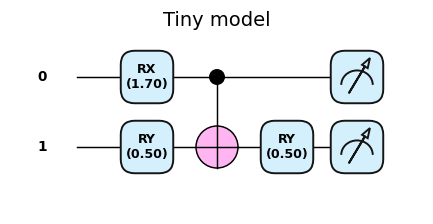

In [16]:
### Plots the circuit
draw_circuit(circuit, scale=0.7, title='Tiny model', style='pennylane')(weights)

In [17]:
### Simple circuit creation and execution
dev = qml.device("lightning.qubit", wires=3) # default.qubit

@qml.qnode(dev)
def circuit(weights):
    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(weights[2], wires=1)
    return [qml.expval(qml.PauliZ(m)) for m in range(2)]

In [18]:
### Apply the circuit to test data
circuit(weights)

[-0.12884449429552475, -0.3290785828968357]

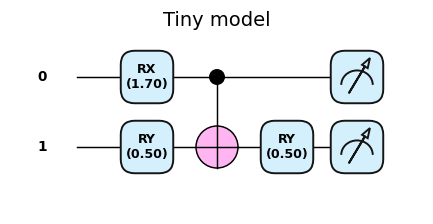

In [19]:
### Plots the circuit
draw_circuit(circuit, scale=0.7, title='Tiny model', style='pennylane')(weights)

In [20]:
### Show gradients at each of the model parameters
qml.gradients.param_shift(circuit)(weights)

[array([-9.91664810e-01, -8.32667268e-17,  2.77555756e-17]),
 array([-0.7637318 , -0.36652604, -0.36652604])]

## Create a simple quantum model

### Model and training configuration

In [21]:
### Data params
n_data = 4
x_angle_margin = 0.1
x_angle_min = 0+x_angle_margin
x_angle_max = nnp.pi-x_angle_margin

### Architectural params
n_wires = n_data
n_layers = 5
scaler = 1
wires = list(range(n_wires))

### Training params
epochs = 60
log_interv = 1
prompt_fract = 0.05
acc_prec = 0.5
shots = 1000
seed = 2024

### Prepare data for the classifier

In [22]:
### Check ranges
print(f'Min X={X_pca.to_numpy().min().round(3)}, Max X={X_pca.to_numpy().max().round(3)}, '+\
      f'Min y={y.to_numpy().min().round(3)}, Max y={y.to_numpy().max().round(3)}')

Min X=-2.276, Max X=3.081, Min y=0, Max y=1


In [23]:
### Standardise X values to the range 0..pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
angle_scaler = MinMaxScaler(feature_range=(x_angle_min, x_angle_max)) 
scaled = angle_scaler.fit_transform(X_pca) 
X = pd.DataFrame(scaled, columns=X_pca.columns)

# Recheck the X ranges
print(f'Min X={X.to_numpy().min().round(3)}, Max X={X.to_numpy().max().round(3)}')

Min X=0.1, Max X=3.042


In [24]:
### Create data partitions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,0:n_data], y.iloc[:,0:n_data], 
                                                    test_size=0.33, random_state=seed)
print(f'Shapes: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}')

Shapes: X_train=(137, 4), X_test=(68, 4), y_train=(137, 1), y_test=(68, 1)


In [25]:
### Change the data format to tensors
X_train_tens = torch.tensor(np.array(X_train), dtype=torch.double)
y_train_tens = torch.tensor(np.array(y_train), dtype=torch.double)
X_test_tens  = torch.tensor(np.array(X_test), dtype=torch.double)
y_test_tens  = torch.tensor(np.array(y_test), dtype=torch.double)

In [26]:
### Sample training predictors
print(X_train_tens[0:5])

tensor([[2.7129, 1.4562, 2.5052, 1.0274],
        [2.1712, 1.1174, 0.6206, 1.6211],
        [1.9172, 0.8760, 0.5968, 0.9686],
        [0.5766, 0.8857, 1.1895, 1.7811],
        [0.9882, 1.6640, 0.8221, 1.2228]], dtype=torch.float64)


In [27]:
### Sample training labels
y_train_tens[0:5]

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.]], dtype=torch.float64)

### Create a model

In [28]:
### Define a simple classifier
def classifier_basis(wires, n_data, n_layers=1, meas_wires=[0], scaler=np.pi):
    
    def _classifier_circ(inputs, weights):
        # inputs: predictors with values in the range of [-1..1] 
        # output: probability of measurement to be 1
        nonlocal wires, n_data, n_layers, meas_wires, scaler
        
        data_wires = wires[0:n_data]
        scaled_inputs = torch.mul(inputs, scaler)
        qml.AngleEmbedding(scaled_inputs, wires=data_wires)        
        qml.StronglyEntanglingLayers(weights, wires=data_wires)
        return [qml.expval(qml.PauliZ(m)) for m in meas_wires]

    return _classifier_circ

### Determine a shape of the classifier
def classifier_basis_shape(n_wires, n_layers=1):
    shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    return shape

In [29]:
### Sample input and weights
print(X_train_tens[0:5], '\n')
weights

tensor([[2.7129, 1.4562, 2.5052, 1.0274],
        [2.1712, 1.1174, 0.6206, 1.6211],
        [1.9172, 0.8760, 0.5968, 0.9686],
        [0.5766, 0.8857, 1.1895, 1.7811],
        [0.9882, 1.6640, 0.8221, 1.2228]], dtype=torch.float64) 



tensor([1.7, 0.5, 0.5], requires_grad=True)

QM shape (60 weights): (5, 4, 3) , Epochs: 60, Shots: 1000, Seed: 2024


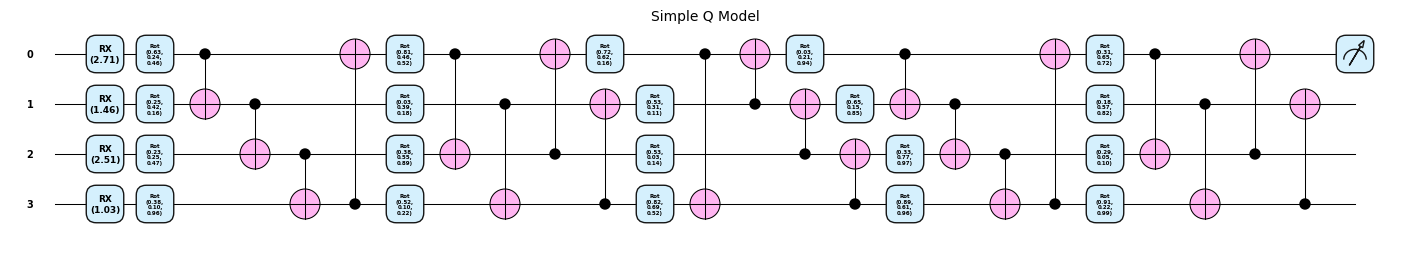

In [30]:
### Create and draw a model circuit, exactly what we'll do in Quantum_Auto
shape = classifier_basis_shape(n_data, n_layers=n_layers)
n_weights = np.prod(shape)
weights = torch.rand(shape, requires_grad=True)
print(f'QM shape ({n_weights} weights): {shape} , Epochs: {epochs}, Shots: {shots}, Seed: {seed}')

model = classifier_basis(wires, n_data, n_layers=n_layers, scaler=scaler) # Try adding: meas_wires=[0, 2]
dev = qml.device(sim, wires=wires, shots=shots)
model_qc = qml.QNode(model, dev, interface='torch', expansion_strategy='gradient')
draw_circuit(model_qc, scale=0.5, title='Simple Q Model', expansion_strategy='device') \
    (X_train_tens[0], weights) # expansion_strategy='device'/'gradient'

In [31]:
### Apply the circuit to example inputs and weights
result = model_qc(X_train_tens[0:5], weights)
print(torch.stack((result)));

tensor([[-0.3540, -0.2460,  0.0500, -0.2420,  0.0740]], dtype=torch.float64,
       grad_fn=<StackBackward0>)


### Model training functions

In [32]:
class Quantum_Auto(nn.Module):

    def __init__(self, sim, n_data, n_layers=1, shots=0, scaler=np.pi):
        super(Quantum_Auto, self).__init__()

        self.sim = sim
        self.n_data = n_data
        self.n_wires = n_data
        self.n_layers = n_layers
        self.wires = list(range(n_wires))
        self.shots = shots
        self.scaler = scaler

        # Create the model
        def_qlayer = self.qlayer()
        layers = [def_qlayer]
        self.model = nn.Sequential(*layers)  

    ### Define a quantum layer
    def qlayer(self):
        
        # Define the model weight shapes
        tensor_shape = classifier_basis_shape(self.n_data, n_layers=self.n_layers)
        weights_shapes = {"weights": tensor_shape}

        # Define the quantum circuit
        model = classifier_basis(self.wires, self.n_data, n_layers=self.n_layers, scaler=self.scaler)
        if self.shots == 0:
            dev = qml.device(self.sim, wires=self.n_wires)
        else:
            dev = qml.device(self.sim, wires=self.n_wires, shots=self.shots)
        model_qc = qml.QNode(model, dev, interface='torch', expansion_strategy='gradient')

        # Turn the circuit into a Torch layer
        qlayer = qml.qnn.TorchLayer(model_qc, weight_shapes=weights_shapes)
        return qlayer

    ### Apply the model to data
    def forward(self, x):
        y = self.model(x)
        return y

In [33]:
### Test if the model works as a function
test = Quantum_Auto(sim, X_train_tens.shape[1], n_layers=n_layers, shots=shots, scaler=scaler).double().to(torch_device)
test(X_train_tens[0:5])

tensor([[-0.1240],
        [ 0.0700],
        [ 0.1160],
        [-0.0060],
        [ 0.0940]], dtype=torch.float64, grad_fn=<ViewBackward0>)

In [34]:
### Trains the classical AE model

def train_quantum(model, X, y, cost_fun, acc_fun, optimizer, epochs, 
                  log_interv=100, prompt_fract=0.1, acc_prec=0.3, start_time=0):
    # global history, acc_hist, opt_params, hist_params
    
    history = []
    acc_hist = []
    opt_params = {}
    hist_params = []
    min_epoch = 0
    min_cost = 1000
    min_acc = 1000
    if start_time == 0: start_time = time.time()
    
    model.train()
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        output = model(X)
        cost = cost_fun(output, y)
        acc = acc_fun(output, y, prec=acc_prec)
        cost.backward()
        optimizer.step()

        curr_loss = cost.item()
        curr_acc = acc
        if curr_loss < min_cost: 
            min_cost = curr_loss
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if curr_acc < min_acc:
            min_acc = curr_acc

        if epoch % log_interv == 0:
            history.append(curr_loss)
            acc_hist.append(curr_acc)
            hist_params.append(copy.deepcopy(model.state_dict()))

        elapsed = time.time() - start_time
        if (prompt_fract == 0) or (epoch % int(prompt_fract*epochs) == 0):
            print(f'{epoch: 5d} '+ \
                  f'({elapsed:06.0f} sec): '+ \
                  f'Loss {curr_loss:6.4g}   '+ \
                  f'Acc {curr_acc:6.4g}')
            
    return history, acc_hist, opt_params, hist_params, (min_epoch, min_cost)


### Model creation and training run

In [35]:
### Set random seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Create a model
q_auto = Quantum_Auto(sim, X_train_tens.shape[1], n_layers=n_layers, shots=shots, scaler=scaler).double().to(torch_device)

### Loss and optimiser

cost_fun = nn.MSELoss()
# cost_fun = nn.L1Loss() # Very poor results

# opt = optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
# opt = torch.optim.Adam(q_auto.parameters())
opt = torch.optim.NAdam(q_auto.parameters(), lr=0.01)

### Show 
q_auto.eval()

Quantum_Auto(
  (model): Sequential(
    (0): <Quantum Torch Layer: func=_classifier_circ>
  )
)

In [36]:
### Train the model
# epochs = 20
# log_interv = 1
# prompt_fract = 0

start_time = time.time()

history, acc_history, opt_params, hist_params, opt_point = \
    train_quantum(q_auto, X_train_tens, y_train_tens, cost_fun, accuracy, opt, epochs, 
                  log_interv=log_interv, prompt_fract=prompt_fract, acc_prec=acc_prec)

elapsed = time.time() - start_time

# Print run statistics
shape = classifier_basis_shape(n_data, n_layers=n_layers)
n_weights = np.prod(shape)

print(f'\n'+
      f'{torch_device}+{sim} Fit ('+
      f'{y_train_tens.shape[0]} samples, '+
      f'{X_train_tens.shape[1]} features, '+
      f'{count_params(q_auto)} params, '+
      f'{epochs} epochs): '+
      f'{round(opt_point[1], 5)} min cost @ iter# {opt_point[0]}, '+
      f'{elapsed:0.2f} sec'+
      f'\n'
     )

    0 (000008 sec): Loss  1.008   Acc 0.4161
    3 (000032 sec): Loss 0.8094   Acc 0.4526
    6 (000055 sec): Loss 0.6724   Acc 0.4672
    9 (000079 sec): Loss 0.5308   Acc 0.4672
   12 (000103 sec): Loss 0.4326   Acc 0.4672
   15 (000127 sec): Loss 0.3552   Acc 0.4672
   18 (000151 sec): Loss 0.3033   Acc 0.4672
   21 (000174 sec): Loss 0.2623   Acc 0.4818
   24 (000198 sec): Loss 0.2402   Acc  0.562
   27 (000222 sec): Loss 0.2192   Acc 0.6496
   30 (000246 sec): Loss 0.2058   Acc 0.7007
   33 (000270 sec): Loss 0.1922   Acc 0.7226
   36 (000294 sec): Loss 0.1874   Acc 0.7664
   39 (000318 sec): Loss 0.1757   Acc 0.7737
   42 (000342 sec): Loss 0.1689   Acc 0.7956
   45 (000365 sec): Loss  0.169   Acc 0.7956
   48 (000389 sec): Loss 0.1617   Acc 0.8175
   51 (000413 sec): Loss 0.1611   Acc 0.8321
   54 (000437 sec): Loss 0.1549   Acc 0.8394
   57 (000462 sec): Loss 0.1565   Acc 0.8175

cpu+lightning.qubit Fit (137 samples, 4 features, 60 params, 60 epochs): 0.15092 min cost @ iter# 5

In [37]:
### Training loss
q_auto.load_state_dict(opt_params)
pred = q_auto(X_train_tens)
print(f'Training acc={nnp.round(accuracy(pred, y_train_tens, prec=0.5), 4)},'+\
      f'loss={nnp.round(square_loss(pred, y_train_tens), 4)}')

Training acc=0.8321,loss=0.1504


In [38]:
### Testing accuracy at the point of the lowest loss
q_auto.load_state_dict(opt_params)
pred = q_auto(X_test_tens)
print(f'Training acc={nnp.round(accuracy(pred, y_test_tens, prec=0.5), 4)},'+\
      f'loss={nnp.round(square_loss(pred, y_test_tens), 4)}')

Training acc=0.8235,loss=0.154


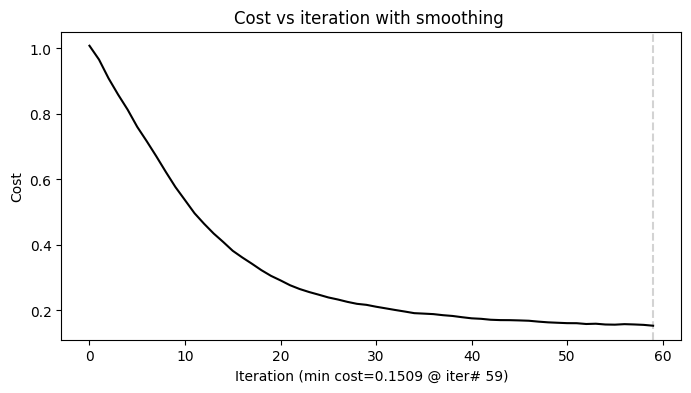

In [39]:
### Plot training cost
meas_plot(history, meas='cost', task='min',
                  rcParams=(8, 4), log_interv=log_interv,
                  backplot=False, back_color='linen', smooth_weight=0.5)

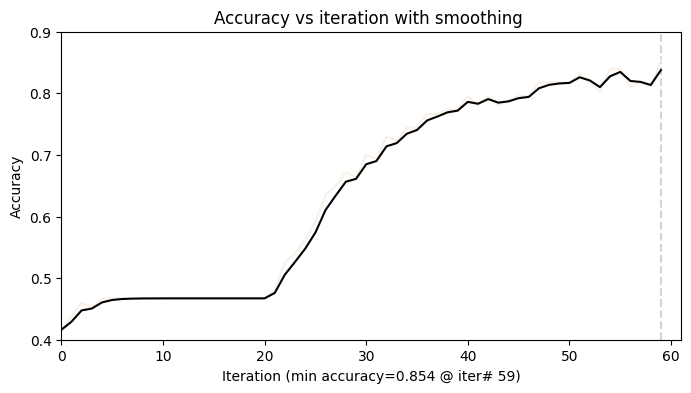

In [42]:
### Plot training accuracy
meas_plot(acc_history, meas='accuracy', task='max',
                  rcParams=(8, 4), log_interv=log_interv, xlim=(0, epochs+1), ylim=(0.4, 0.9),
                  backplot=True, back_color='linen', smooth_weight=0.4)

## What's next?
*At this point you can improve this notebook by performing the following tasks:*

- Save the history of loss and accuracy into a resource folder
- Save all model parameters kept during the model training into a resource folder
- Calculate, plot and archive MSE and accuracy scores for test data partition
- Play with the smoothing factor in all plots to gain insight into volatility of your scores
- Analyse all accumulated data and report your observations, reflect on your learning

*As an extension:*

- Prepare an Automobile data set, a model and its scores, to predict car price (exclude symboling which is a variable dependent on price)
- Repeat the entire process for the "sonar" data set (link included above)
- Enjoy learning predictive analytics using classical and quantum ML models

## System in use

In [43]:
!pip list | grep -e PennyLane -e torch

PennyLane                     0.38.0
PennyLane_Lightning           0.38.0
PennyLane_Lightning_GPU       0.38.0
torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0
